In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import argparse
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm, linear_model,neighbors
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
import seaborn as sns
import joblib
import torch
import torch.nn as nn
from torchvision.transforms import Resize, ToTensor, Compose, Normalize, transforms
from torchvision.models import resnet34, resnet18
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [ ]:
def get_parser():
    data_path_default = r"/content/drive/MyDrive/Doan_CS231/dataset"
    parser = argparse.ArgumentParser(description="Do An CS231")
    parser.add_argument("--data_path", "-d", type=str, default=data_path_default, help="path to the dataset")
    parser.add_argument("--image_size", "-i", type=int, default= 224)
    parser.add_argument("--model_resnet", "-r", type=str, default=os.path.join(os.path.dirname(data_path_default), 'resnet_model.pth'), help="please enter path")
    parser.add_argument("--model_svm", "-s", type=str, default=os.path.join(os.path.dirname(data_path_default), 'svm_model.pkl'), help="please enter path")
    parser.add_argument("--imagetest_path", type= str, default = r"/content/drive/MyDrive/image_test/Image2A9Flarge.jpg", help ="please enter path image_test")
    try:
        args = parser.parse_args()
    except SystemExit:
        # Default values will be used when running in a Jupyter notebook
        args = parser.parse_args(args=[])
    return args

args = get_parser()


usage: colab_kernel_launcher.py [-h] [--data_path DATA_PATH] [--image_size IMAGE_SIZE]
                                [--model_resnet MODEL_RESNET] [--model_svm MODEL_SVM]
                                [--imagetest_path IMAGETEST_PATH]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-d6552771-9bc0-461c-b884-8d4732209872.json


#Load Data


In [ ]:
categories = ['Bọ rùa 28 chấm', 'Sâu xám', 'Bọ xít nâu dài', 'Sâu bắp cải', 'Bọ xít hút máu', 'Ruồi Địa Trung Hải', 'Bọ xít', 'Bọ nhảy']

In [ ]:
image_paths= []
labels = []
categories = ['Bọ rùa 28 chấm', 'Sâu xám', 'Bọ xít nâu dài', 'Sâu bắp cải', 'Bọ xít hút máu', 'Ruồi Địa Trung Hải', 'Bọ xít', 'Bọ nhảy']
for index, category in enumerate(categories):
  subdir_path = os.path.join(args.data_path , category)
  for file_name in os.listdir(subdir_path):
    image_path = os.path.join(subdir_path, file_name)
    image_paths.append(image_path)
    labels.append(index)
labels = np.array(labels)

# Extract feature

## HSV Histogram

In [ ]:
def extract_color_histogram(image_path, bins=(8, 8, 8)):
    # Đọc ảnh
    image = cv2.imread(image_path)
    image = cv2.resize(image, (args.image_size, args.image_size))

    # Chuyển đổi ảnh sang không gian màu HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Tính toán histogram màu
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])

    # Chuẩn hóa histogram
    cv2.normalize(hist, hist)

    # Trả về histogram dưới dạng vector đặc trưng
    return hist.flatten()

In [ ]:
for i in range(1, 5):
  x = []
  for image_path in tqdm(image_paths):
    x.append(extract_color_histogram(image_path, bins=(i,i,i)))
  feat_hist_df = pd.DataFrame(x)
  feat_hist_df.to_csv(f"/content/drive/MyDrive/Doan_CS231/Features/feat_hist_bins_{i}.csv")

## Resnet 18

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((args.image_size, args.image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = transform(image)
    image = image.unsqueeze(0)
    return image.to(device)

In [ ]:
def extract_features(image, model):
    with torch.no_grad():
        feature = model(image).squeeze().cpu().numpy()
    return feature

In [ ]:
def extract_features_from_image(image_path, model):
    image = preprocess_image(image_path)
    feature = extract_features(image, model)
    return feature

In [ ]:
resnet18_model = resnet18(pretrained=True)
resnet18_model = nn.Sequential(*list(resnet18_model.children())[:-1])
resnet18_model = resnet18_model.to(device)
resnet18_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
features_resnet18 = []
for image_path in tqdm(image_paths):
  features_resnet18.append(extract_features_from_image(image_path, resnet18_model))

 60%|██████    | 1755/2902 [03:59<02:39,  7.17it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 2902/2902 [06:32<00:00,  7.39it/s]


In [ ]:
features_resnet18 = []
if os.path.isfile("/content/drive/MyDrive/Doan_CS231/Features/resnet18/feat_resnet18.xlsx"):
  features_resnet18 = np.array(pd.read_excel("/content/drive/MyDrive/Doan_CS231/Features/resnet18/feat_resnet18.xlsx"))

#Grid Search

## HSV Histogram

### Load Feature

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Doan_CS231/Features/feat_hist_bins_8.csv")
df_np = df.to_numpy()
x = np.delete(df_np, 0, axis=1)
x[0].shape

(512,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size = 0.2, random_state = 42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)
_, _, _, paths_test = train_test_split(x, image_paths, test_size = 0.2, random_state = 42)

### SVM

In [ ]:
def grid_search_svm(C_list, kernel_list, degree_list, gamma_list):
  result = pd.DataFrame(columns=['C', 'kernel', 'degree', 'gamma', 'accuracy', 'macro F1 score'])
  index = 0
  for C in tqdm(C_list):
    for kernel in kernel_list:
      if kernel == 'poly':
        for degree in degree_list:
          for gamma in gamma_list:
            index += 1
            clf_svm = svm.SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, random_state=42)
            clf_svm.fit(X_train, y_train)
            preds_svm = clf_svm.predict(X_val)
            acc_svm = accuracy_score(y_val, preds_svm)
            f1_svm = f1_score(y_val, preds_svm, average='macro')
            conf_mat_svm = confusion_matrix(y_val, preds_svm)
            result.loc[index] = {
                'C': C,
                'kernel': kernel,
                'degree': degree,
                'gamma': gamma,
                'accuracy': acc_svm,
                'macro F1 score': f1_svm
            }
      else:
        for gamma in gamma_list:
          index += 1
          clf_svm = svm.SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
          clf_svm.fit(X_train, y_train)
          preds_svm = clf_svm.predict(X_val)
          acc_svm = accuracy_score(y_val, preds_svm)
          f1_svm = f1_score(y_val, preds_svm, average='macro')
          conf_mat_svm = confusion_matrix(y_val, preds_svm)
          result.loc[index] = {
              'C': C,
              'kernel': kernel,
              'degree': 0,
              'gamma': gamma,
              'accuracy': acc_svm,
              'macro F1 score': f1_svm
          }
  result.to_excel('/content/drive/MyDrive/Doan_CS231/Results/bins_4/svm_hist(C 29-32).xlsx')

In [ ]:
C_list = np.arange(29, 32.1, .1)
degree_list = np.arange(0, 21, 1)
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
gamma_list = ['scale', 'auto']
grid_search_svm(C_list, kernel_list, degree_list, gamma_list)

100%|██████████| 32/32 [09:40<00:00, 18.14s/it]


In [ ]:
clf_svm = svm.SVC(C=55, kernel='rbf', gamma='scale', random_state=42)
clf_svm.fit(X_train, y_train)
preds_svm = clf_svm.predict(X_test)
acc_svm = accuracy_score(y_test, preds_svm)
conf_mat_svm = confusion_matrix(y_test, preds_svm)

In [ ]:
print(classification_report(y_test, preds_svm))

              precision    recall  f1-score   support

           0       0.53      0.58      0.55        71
           1       0.59      0.56      0.58        78
           2       0.40      0.36      0.38        70
           3       0.71      0.71      0.71        66
           4       0.56      0.62      0.59        72
           5       0.67      0.82      0.74        65
           6       0.57      0.52      0.55        75
           7       0.53      0.46      0.50        84

    accuracy                           0.57       581
   macro avg       0.57      0.58      0.57       581
weighted avg       0.57      0.57      0.57       581



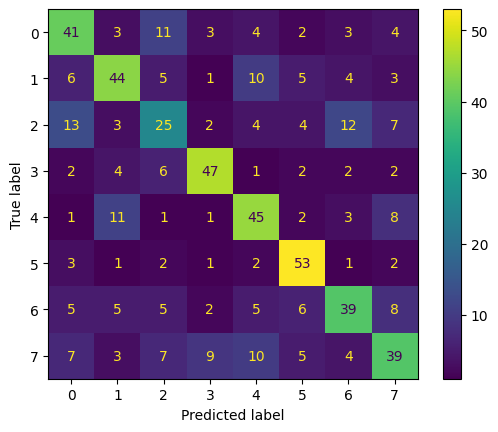

In [ ]:
plot = ConfusionMatrixDisplay(conf_mat_svm)
plot.plot()

### KNN

In [ ]:
def grid_search_knn(neighbors_list):
  result = pd.DataFrame(columns=['n', 'accuracy', 'macro F1 score'])
  index = 0
  for n in tqdm(neighbors_list):
    index += 1
    clf_knn = neighbors.KNeighborsClassifier(n_neighbors=n)
    clf_knn.fit(X_train, y_train)
    preds_knn = clf_knn.predict(X_val)
    acc_knn = accuracy_score(y_val, preds_knn)
    f1_knn = f1_score(y_val, preds_knn, average='macro')
    conf_mat_knn = confusion_matrix(y_val, preds_knn)
    result.loc[index] = {
        'n': n,
        'accuracy': acc_knn,
        'macro F1 score': f1_knn
    }
  result.to_excel('/content/drive/MyDrive/Doan_CS231/Results/bins_8/knn_hist.xlsx')

In [ ]:
neighbors_list = np.arange(2, 51, 1)
grid_search_knn(neighbors_list)

100%|██████████| 49/49 [00:07<00:00,  6.59it/s]


In [ ]:
clf_knn = neighbors.KNeighborsClassifier(n_neighbors=2)
clf_knn.fit(X_train, y_train)
preds_knn = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, preds_knn)
conf_mat_knn = confusion_matrix(y_test, preds_knn)

In [ ]:
print(classification_report(y_test, preds_knn))

              precision    recall  f1-score   support

           0       0.36      0.62      0.46        71
           1       0.39      0.54      0.45        78
           2       0.23      0.26      0.24        70
           3       0.57      0.53      0.55        66
           4       0.47      0.42      0.44        72
           5       0.61      0.68      0.64        65
           6       0.54      0.35      0.42        75
           7       0.53      0.19      0.28        84

    accuracy                           0.44       581
   macro avg       0.46      0.45      0.44       581
weighted avg       0.46      0.44      0.43       581



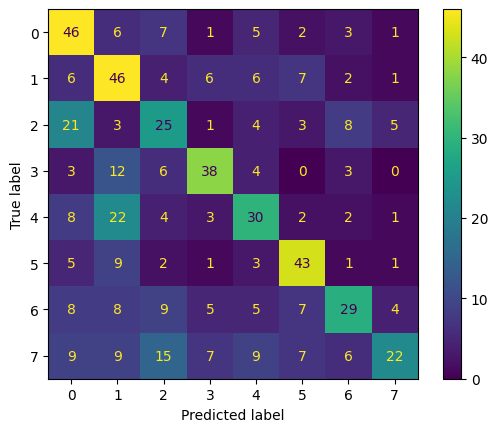

In [ ]:
plot = ConfusionMatrixDisplay(conf_mat_knn)
plot.plot()

### SOFTMAX

In [ ]:
def grid_search_softmax(penalty_list, C_list, solver_list):
  result = pd.DataFrame(columns=['penalty', 'C', 'solver', 'multi_class', 'accuracy', 'macro F1 score'])
  index = 0
  for penalty in tqdm(penalty_list):
    for C in C_list:
        for solver in solver_list:
          if (penalty == 'l1' and (solver == 'lbfgs' or solver == 'newton-cg' or solver == 'newton-cholesky' or solver == 'sag')): continue
          index += 1
          Softmax_model = linear_model.LogisticRegression(penalty=penalty, C=C, multi_class='multinomial', solver=solver, random_state=42)
          Softmax_model.fit(X_train, y_train)
          pred_softmax = Softmax_model.predict(X_val)
          acc_softmax = accuracy_score(y_val, pred_softmax)
          cm = confusion_matrix(y_val, pred_softmax)
          f1_softmax = f1_score(y_val, pred_softmax, average='macro')
          result.loc[index] = {
              'penalty': penalty,
              'C': C,
              'solver': solver,
              'multi_class': 'multinomial',
              'accuracy': acc_softmax,
              'macro F1 score': f1_softmax
          }
  result.to_excel('/content/drive/MyDrive/Doan_CS231/Results/bins_8/softmax_hist(C 0-100, step 5).xlsx')

In [ ]:
penalty_list = ['l1', 'l2', None]
C_list = np.arange(1e-5, 105, 5)
solver_list = ['lbfgs', 'newton-cg', 'sag', 'saga']
grid_search_softmax(penalty_list, C_list, solver_list)

In [ ]:
Softmax_model = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg',penalty=None, random_state=42)
Softmax_model.fit(X_train, y_train)
pred_softmax = Softmax_model.predict(X_test)
accuracy_score(y_test, pred_softmax)
cm = confusion_matrix(y_test, pred_softmax)

In [ ]:
print(classification_report(y_test, preds_knn))

              precision    recall  f1-score   support

           0       0.36      0.62      0.46        71
           1       0.39      0.54      0.45        78
           2       0.23      0.26      0.24        70
           3       0.57      0.53      0.55        66
           4       0.47      0.42      0.44        72
           5       0.61      0.68      0.64        65
           6       0.54      0.35      0.42        75
           7       0.53      0.19      0.28        84

    accuracy                           0.44       581
   macro avg       0.46      0.45      0.44       581
weighted avg       0.46      0.44      0.43       581



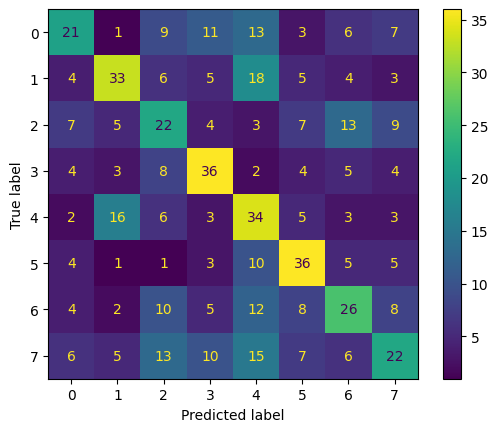

In [ ]:
plot = ConfusionMatrixDisplay(cm)
plot.plot()

## Resnet 18

### Load Feature

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Doan_CS231/Features/feat_resnet18.csv")
df_np = df.to_numpy()
features_resnet18_1 = np.delete(df_np, 0, axis=1)
features_resnet18_1[0].shape

(512,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_resnet18_1, labels, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

### SVM

In [ ]:
def grid_search_svm(C_list, kernel_list, degree_list, gamma_list):
  result = pd.DataFrame(columns=['C', 'kernel', 'degree', 'gamma', 'accuracy', 'macro F1 score'])
  index = 0
  for C in tqdm(C_list):
    for kernel in kernel_list:
      if kernel == 'poly':
        for degree in degree_list:
          for gamma in gamma_list:
            index += 1
            clf_svm = svm.SVC(C=C, kernel=kernel, degree=degree, gamma=gamma, random_state=42)
            clf_svm.fit(X_train, y_train)
            preds_svm = clf_svm.predict(X_val)
            acc_svm = accuracy_score(y_val, preds_svm)
            f1_svm = f1_score(y_val, preds_svm, average='macro')
            conf_mat_svm = confusion_matrix(y_val, preds_svm)
            result.loc[index] = {
                'C': C,
                'kernel': kernel,
                'degree': degree,
                'gamma': gamma,
                'accuracy': acc_svm,
                'macro F1 score': f1_svm
            }
      else:
        for gamma in gamma_list:
          index += 1
          clf_svm = svm.SVC(C=C, kernel=kernel, gamma=gamma, random_state=42)
          clf_svm.fit(X_train, y_train)
          preds_svm = clf_svm.predict(X_val)
          acc_svm = accuracy_score(y_val, preds_svm)
          f1_svm = f1_score(y_val, preds_svm, average='macro')
          conf_mat_svm = confusion_matrix(y_val, preds_svm)
          result.loc[index] = {
              'C': C,
              'kernel': kernel,
              'degree': 0,
              'gamma': gamma,
              'accuracy': acc_svm,
              'macro F1 score': f1_svm
          }
  result.to_excel('/content/drive/MyDrive/Doan_CS231/Results/svm_resnet18 (C 3-5).xlsx')

In [ ]:
C_list = np.arange(3, 5.1, .1)
degree_list = np.arange(0, 21, 1)
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
gamma_list = ['scale', 'auto']
grid_search_svm(C_list, kernel_list, degree_list, gamma_list)

100%|██████████| 21/21 [11:04<00:00, 31.63s/it]


In [ ]:
clf_svm = svm.SVC(C=5, kernel='rbf', gamma='scale', random_state=42)
clf_svm.fit(X_train, y_train)
preds_svm_res = clf_svm.predict(X_test)
acc_svm = accuracy_score(y_test, preds_svm_res)
conf_mat_svm = confusion_matrix(y_test, preds_svm_res)

In [ ]:
print(classification_report(y_test, preds_svm_res))

              precision    recall  f1-score   support

           0       0.55      0.52      0.54        71
           1       0.65      0.58      0.61        78
           2       0.38      0.34      0.36        70
           3       0.72      0.73      0.72        66
           4       0.54      0.68      0.60        72
           5       0.63      0.78      0.70        65
           6       0.55      0.53      0.54        75
           7       0.52      0.43      0.47        84

    accuracy                           0.57       581
   macro avg       0.57      0.57      0.57       581
weighted avg       0.56      0.57      0.56       581



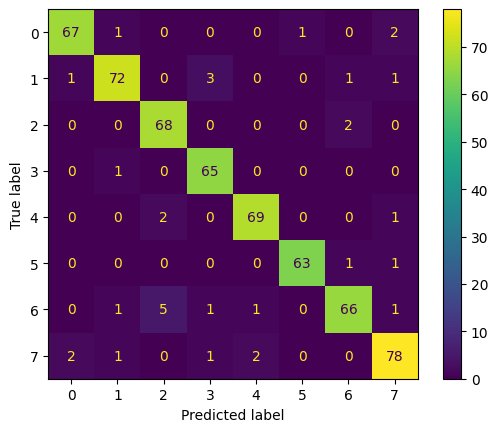

In [ ]:
plot = ConfusionMatrixDisplay(conf_mat_svm)
plot.plot()

### KNN

In [ ]:
def grid_search_knn(neighbors_list):
  result = pd.DataFrame(columns=['n', 'accuracy', 'macro F1 score'])
  index = 0
  for n in neighbors_list:
    index += 1
    clf_knn = neighbors.KNeighborsClassifier(n_neighbors=n)
    clf_knn.fit(X_train, y_train)
    preds_knn = clf_knn.predict(X_val)
    acc_knn = accuracy_score(y_val, preds_knn)
    f1_knn = f1_score(y_val, preds_knn, average='macro')
    conf_mat_knn = confusion_matrix(y_val, preds_knn)
    result.loc[index] = {
        'n': n,
        'accuracy': acc_knn,
        'macro F1 score': f1_knn
    }
  result.to_excel('/content/drive/MyDrive/Doan_CS231/Results/knn_resnet18.xlsx')

In [ ]:
neighbors_list = np.arange(2, 51, 1)
grid_search_knn(neighbors_list)

In [ ]:
clf_knn = neighbors.KNeighborsClassifier(n_neighbors=12)
clf_knn.fit(X_train, y_train)
preds_knn = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, preds_knn)
conf_mat_knn = confusion_matrix(y_test, preds_knn)

In [ ]:
print(classification_report(y_test, preds_knn, target_names = categories))

                    precision    recall  f1-score   support

    Bọ rùa 28 chấm       0.86      0.97      0.91        71
           Sâu xám       0.96      0.83      0.89        78
    Bọ xít nâu dài       0.68      0.97      0.80        70
       Sâu bắp cải       0.74      0.97      0.84        66
    Bọ xít hút máu       0.94      0.82      0.87        72
Ruồi Địa Trung Hải       0.92      0.92      0.92        65
            Bọ xít       0.90      0.60      0.72        75
           Bọ nhảy       0.97      0.80      0.88        84

          accuracy                           0.86       581
         macro avg       0.87      0.86      0.85       581
      weighted avg       0.88      0.86      0.85       581



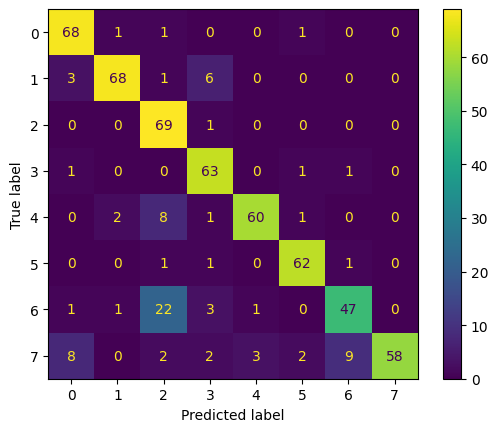

In [ ]:
plot = ConfusionMatrixDisplay(conf_mat_knn)
plot.plot()

### SOFTMAX

In [ ]:
def grid_search_softmax(penalty_list, C_list, solver_list):
  result = pd.DataFrame(columns=['penalty', 'C', 'solver', 'multi_class', 'accuracy', 'macro F1 score'])
  index = 0
  for penalty in tqdm(penalty_list):
    for C in C_list:
        for solver in solver_list:
          if (penalty == 'l1' and (solver == 'lbfgs' or solver == 'newton-cg' or solver == 'newton-cholesky' or solver == 'sag')): continue
          index += 1
          Softmax_model = linear_model.LogisticRegression(penalty=penalty, C=C, multi_class='multinomial', solver=solver, random_state=42)
          Softmax_model.fit(X_train, y_train)
          pred_softmax = Softmax_model.predict(X_val)
          acc_softmax = accuracy_score(y_val, pred_softmax)
          cm = confusion_matrix(y_val, pred_softmax)
          f1_softmax = f1_score(y_val, pred_softmax, average='macro')
          result.loc[index] = {
              'penalty': penalty,
              'C': C,
              'solver': solver,
              'multi_class': 'multinomial',
              'accuracy': acc_softmax,
              'macro F1 score': f1_softmax
          }
  result.to_excel('/content/drive/MyDrive/Doan_CS231/Results/softmax_resnet18 C(0-5).xlsx')

In [ ]:
penalty_list = ['l1', 'l2', None]
C_list = np.arange(1e-5, 6, 1)
solver_list = ['lbfgs', 'newton-cg', 'sag', 'saga']
grid_search_softmax(penalty_list, C_list, solver_list)

In [ ]:
Softmax_model = linear_model.LogisticRegression(multi_class='multinomial', solver='saga', penalty='l1', C=5, random_state=42)
Softmax_model.fit(X_train, y_train)
pred_softmax = Softmax_model.predict(X_test)

In [ ]:
accuracy_score(y_test, pred_softmax)
cm = confusion_matrix(y_test, pred_softmax)

In [ ]:
print(classification_report(y_test, pred_softmax))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        71
           1       0.93      0.90      0.92        78
           2       0.89      0.93      0.91        70
           3       0.88      0.95      0.91        66
           4       0.90      0.97      0.93        72
           5       0.94      0.94      0.94        65
           6       0.93      0.85      0.89        75
           7       0.93      0.90      0.92        84

    accuracy                           0.92       581
   macro avg       0.92      0.92      0.92       581
weighted avg       0.92      0.92      0.92       581



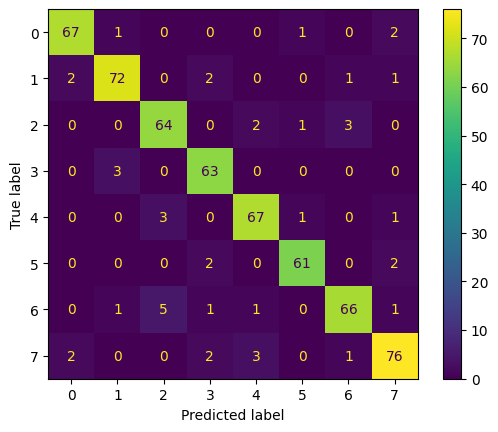

In [ ]:
plot = ConfusionMatrixDisplay(cm)
plot.plot()

# Inference_image

In [ ]:
true_list=[]
false_list=[]
for i, j, j1, path in zip(y_test, preds_svm, preds_svm_res, paths_test):
  if(i!=j):
    print(f"Path:{path} Actual: {categories[i]} - Predict_his: {categories[j]} - Predict_res: {categories[j1]}")
    thisdict = {
                  "Path":path,
                  "Actual": categories[i],
                  "Predict_hist": categories[j],
                  "Predict_res": categories[j1]
                }
    false_list.append(thisdict)
  else:
    print(f"Path:{path} Actual: {categories[i]} - Predict_his: {categories[j]} - Predict_res: {categories[j1]}")
    thisdict = {
                  "Path":path,
                  "Actual": categories[i],
                  "Predict_hist": categories[j],
                  "Predict_res": categories[j1]
                }
    true_list.append(thisdict)

Path:/content/drive/MyDrive/Doan_CS231/dataset/Bọ rùa 28 chấm/Epilachna vigintioctopunctata_288.jpg Actual: Bọ rùa 28 chấm - Predict_his: Sâu bắp cải - Predict_res: Sâu bắp cải
Path:/content/drive/MyDrive/Doan_CS231/dataset/Bọ xít nâu dài/Riptortus_420.jpg Actual: Bọ xít nâu dài - Predict_his: Sâu xám - Predict_res: Bọ nhảy
Path:/content/drive/MyDrive/Doan_CS231/dataset/Sâu xám/Cutworm_308.jpg Actual: Sâu xám - Predict_his: Sâu xám - Predict_res: Sâu xám
Path:/content/drive/MyDrive/Doan_CS231/dataset/Bọ xít hút máu/Boxelder Bugs_87.jpg Actual: Bọ xít hút máu - Predict_his: Bọ xít - Predict_res: Bọ xít
Path:/content/drive/MyDrive/Doan_CS231/dataset/Sâu bắp cải/Cabbage Looper_280.jpg Actual: Sâu bắp cải - Predict_his: Sâu bắp cải - Predict_res: Sâu bắp cải
Path:/content/drive/MyDrive/Doan_CS231/dataset/Bọ nhảy/Flea Beetles_46.jpg Actual: Bọ nhảy - Predict_his: Bọ nhảy - Predict_res: Bọ nhảy
Path:/content/drive/MyDrive/Doan_CS231/dataset/Sâu bắp cải/Cabbage Looper_38.jpg Actual: Sâu bắp c

In [ ]:
true_list

[{'Path': '/content/drive/MyDrive/Doan_CS231/dataset/Sâu xám/Cutworm_308.jpg',
  'Actual': 'Sâu xám',
  'Predict_hist': 'Sâu xám',
  'Predict_res': 'Sâu xám'},
 {'Path': '/content/drive/MyDrive/Doan_CS231/dataset/Sâu bắp cải/Cabbage Looper_280.jpg',
  'Actual': 'Sâu bắp cải',
  'Predict_hist': 'Sâu bắp cải',
  'Predict_res': 'Sâu bắp cải'},
 {'Path': '/content/drive/MyDrive/Doan_CS231/dataset/Bọ nhảy/Flea Beetles_46.jpg',
  'Actual': 'Bọ nhảy',
  'Predict_hist': 'Bọ nhảy',
  'Predict_res': 'Bọ nhảy'},
 {'Path': '/content/drive/MyDrive/Doan_CS231/dataset/Sâu bắp cải/Cabbage Looper_38.jpg',
  'Actual': 'Sâu bắp cải',
  'Predict_hist': 'Sâu bắp cải',
  'Predict_res': 'Sâu bắp cải'},
 {'Path': '/content/drive/MyDrive/Doan_CS231/dataset/Ruồi Địa Trung Hải/Mediterranean fruit fly_530.jpg',
  'Actual': 'Ruồi Địa Trung Hải',
  'Predict_hist': 'Ruồi Địa Trung Hải',
  'Predict_res': 'Ruồi Địa Trung Hải'},
 {'Path': '/content/drive/MyDrive/Doan_CS231/dataset/Bọ nhảy/Flea Beetles_236.jpg',
  'Actu

In [ ]:
import matplotlib.pyplot as plt
def display_image_prediction(path, true_label, predicted_label):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(f"Thực tế: {true_label}\nDự đoán: {predicted_label}")
    plt.axis('off')
    # plt.show()

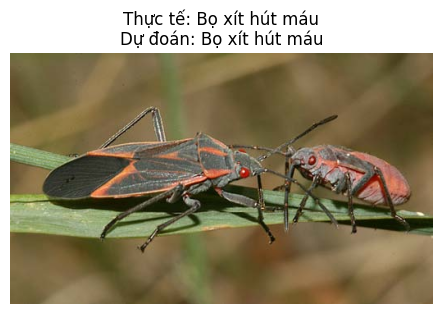

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
display_image_prediction(true_list[6]["Path"],true_list[6]["Actual"],true_list[6]["Predict_hist"])


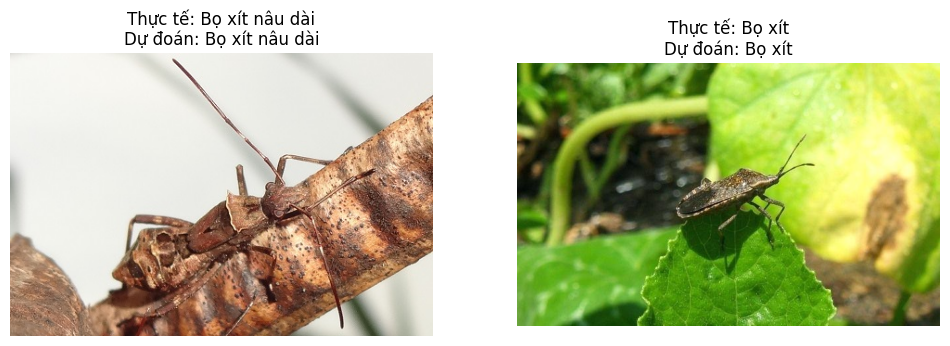

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
display_image_prediction(false_list[10]["Path"],false_list[10]["Actual"],false_list[10]["Predict_res"])
plt.subplot(1, 2, 2)
display_image_prediction(false_list[100]["Path"],false_list[100]["Actual"],false_list[100]["Predict_res"])
plt.show()